# Project Report

**Outline**  
The steps performed in this notebook are as follows:
1. Install and import dependencies
2. Load and preprocess the required dataframes
3. Visualize correlations between weather and audio features
4. Train and evaluate a Random Forest Regressor model to predict a songs popularity (based on weather and audio features)
5. Download and preprocess the latest weather data and trending songs
6. Utilize the RFR to recommend one of the songs

## 1. Install and import dependencies

In [2]:
%%capture
%pip install ftplib
%pip install ipython
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install shutil
%pip install spotipy
%pip install sqlalchemy
%pip install zipfile

In [13]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import spotipy
import zipfile

from ftplib import FTP
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## 2. Load and preprocess the required dataframes

- **cloud_df**
  - bedeckungsgrad: *estimated coverage of the visible sky with clouds in eighths*
- **rain_df**
  - niederschlagshoehe: *precipitation height in mm*
  - schneehoehe_cm: *snow height in cm*
  - neuschneehoehe_cm: *fresh snow height in cm*
- **temperature_df**
  - lufttemperatur: *air temperature in °C*
  - rel_feuchte: *relative humidity in %*
- **wind_df**
  - windstaerke: *wind speed in Bft*
- **songs_df**
  - date: *day of chart observation*
  - position: *1-200 position in charts*
  - track_id: *unique spotify id for each song*
  - track: *track and artist*
  - title: *song's title*
  - artist: *song's artist*
- **audio_features_df**
  - see [here](../data/audio_features_meaning.md)

In [4]:
db_uri = "sqlite:///../data.sqlite"

cloud_df = pd.read_sql_table("cloud_data", db_uri, columns=["mess_datum", "bedeckungsgrad"])
rain_df = pd.read_sql_table("rain_data", db_uri, columns=["mess_datum", "niederschlagshoehe_mm", "schneehoehe_cm", "neuschneehoehe_cm"])
temperature_df = pd.read_sql_table("temperature_data", db_uri, columns=["mess_datum", "lufttemperatur", "rel_feuchte"])
wind_df = pd.read_sql_table("wind_data", db_uri, columns=["mess_datum", "windstaerke"])
songs_df = pd.read_sql_table("spotify_data", db_uri)
audio_features_df = pd.read_sql_table("audio_features", db_uri)

In [5]:
def preprocess (df):
    df.replace(-999, pd.NA, inplace=True)
    df["date"] = pd.to_datetime(df["mess_datum"]).dt.date
    df.drop("mess_datum", axis=1, inplace=True)
    df = df.groupby("date").mean().reset_index()
    return df

songs_df["date"] = pd.to_datetime(songs_df["date"]).dt.date

cloud_df = preprocess(cloud_df)
rain_df = preprocess(rain_df)
temperature_df = preprocess(temperature_df)
wind_df = preprocess(wind_df)

## 3. Visualize correlations between weather and audio features

In [ ]:
x_vars = list(audio_features_df.columns.values)
x_vars.remove("track_id")
x_vars.remove("mode")

def plot_lines(df: pd.DataFrame, title: str, n_bins: int = 20, order: int = 1):
    # Create bins
    df["bin"] = pd.cut(df[title], n_bins)
    bins = df["bin"].cat.categories
    avg_values = [(bin.left + bin.right) / 2 for bin in bins]
    bin_counts = df["bin"].value_counts().sort_index()
    print(f"Bin Counts:\n{bin_counts}")

    for var in x_vars:
        mean_feature_val_df = df.groupby("bin")[var].mean().reset_index()
        # Plot the relationship between binned weather feature and mean audio feature value
        plt.figure(figsize=(10, 6))
        plt.plot(avg_values, mean_feature_val_df[var], marker="o")
        sns.regplot(x=avg_values, y=mean_feature_val_df[var], marker="o", color=".2", order=order, ci=90,)
        plt.xlabel(title)
        plt.ylabel(f"Average {var}")
        plt.title(f"Relationship between {title} and Mean {var} of Songs")
        plt.grid(True)
        plt.show()

In [ ]:
merged_df = temperature_df[["date", "lufttemperatur"]]
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["lufttemperatur"] + x_vars,
             y_vars=["lufttemperatur"])
plt.show()
plot_lines(merged_df, "lufttemperatur", 25, 2)

KeyboardInterrupt: 

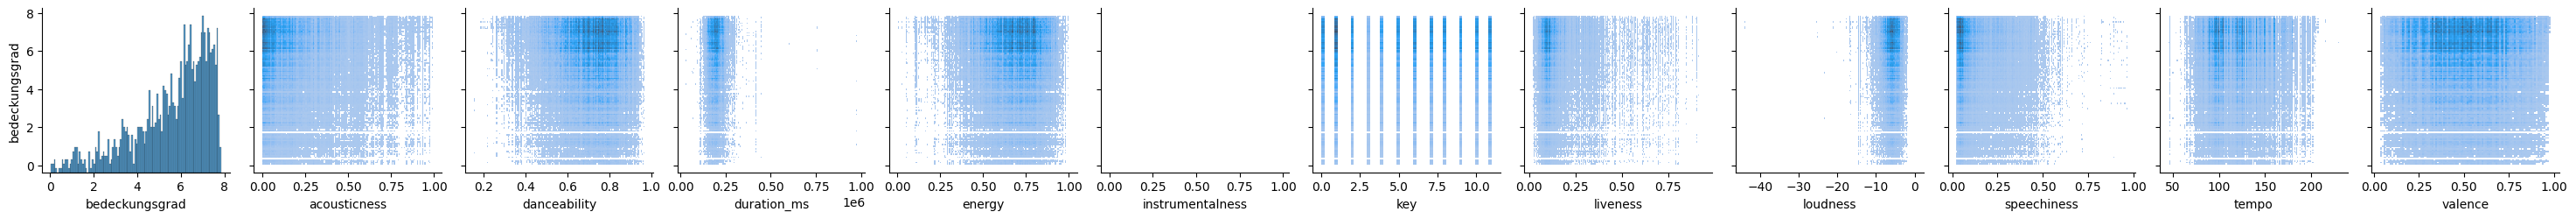

Bin Counts:
bin
(0.0128, 0.412]     1800
(0.412, 0.804]      2200
(0.804, 1.196]      4000
(1.196, 1.587]      3600
(1.587, 1.979]      2200
(1.979, 2.37]       5600
(2.37, 2.762]       4800
(2.762, 3.154]      6200
(3.154, 3.545]     10200
(3.545, 3.937]      7600
(3.937, 4.329]     10200
(4.329, 4.72]      13600
(4.72, 5.112]      15800
(5.112, 5.503]     18400
(5.503, 5.895]     18400
(5.895, 6.287]     27999
(6.287, 6.678]     30400
(6.678, 7.07]      33800
(7.07, 7.462]      34200
(7.462, 7.853]     24000
Name: count, dtype: int64


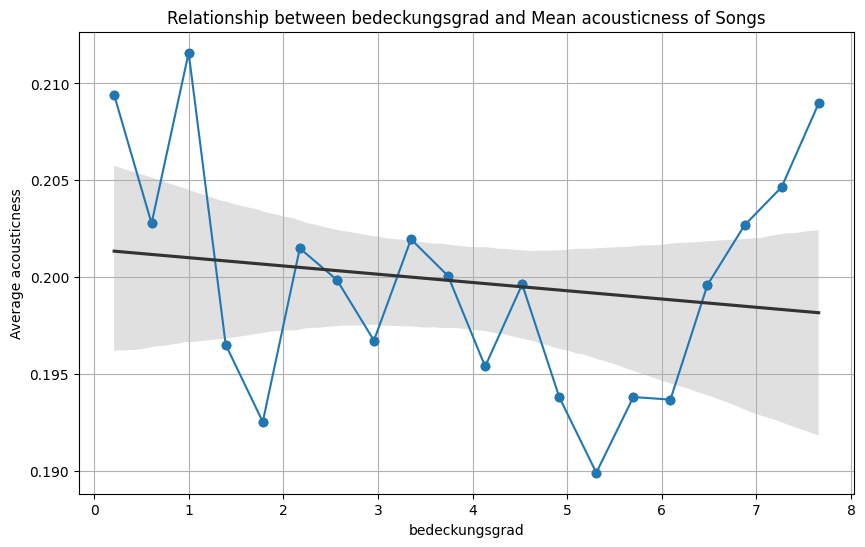

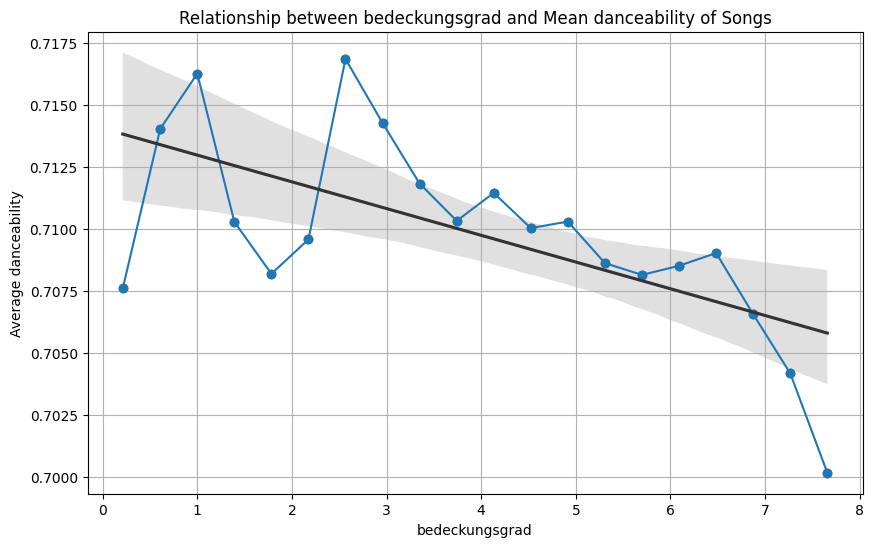

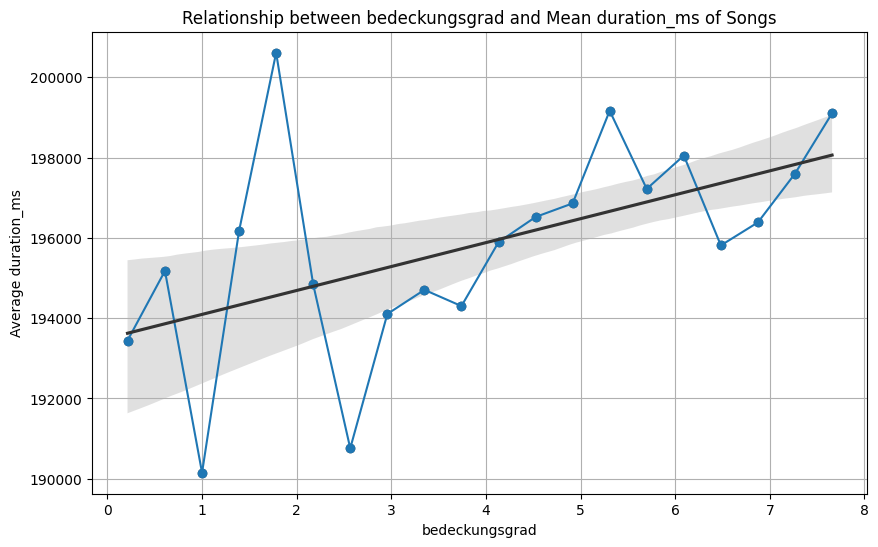

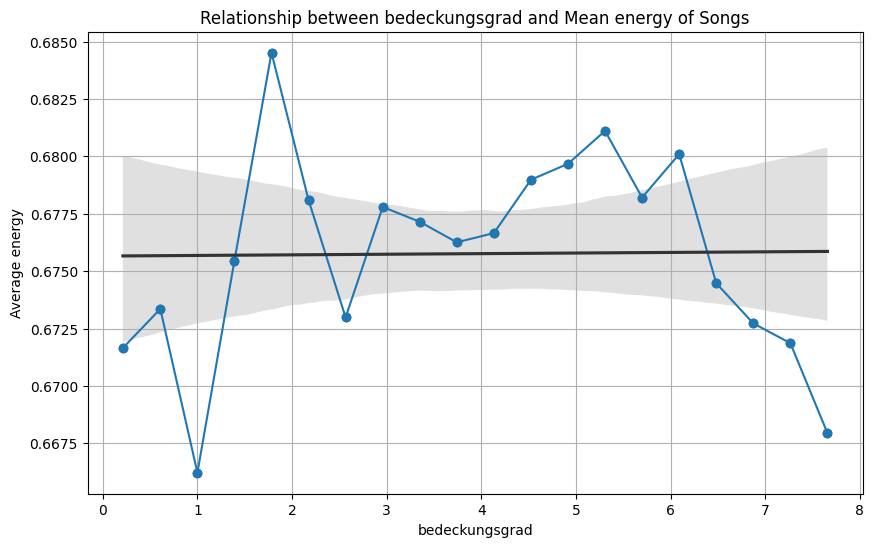

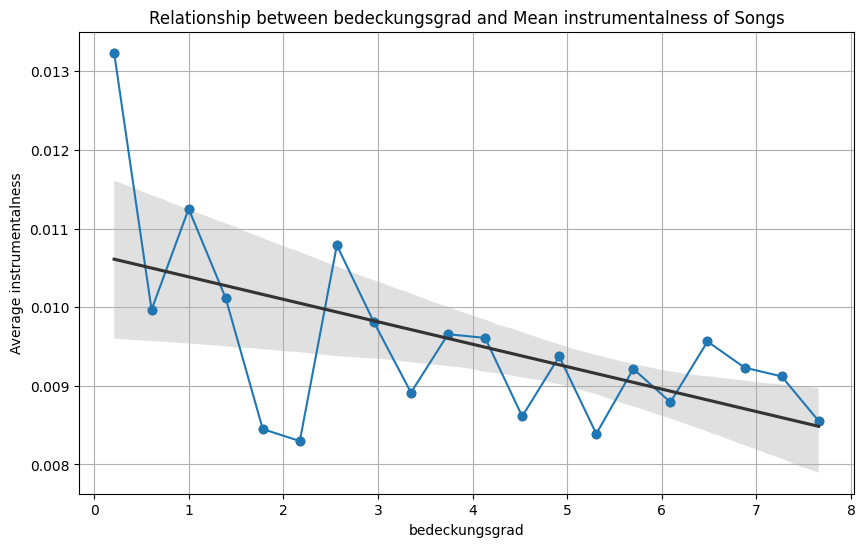

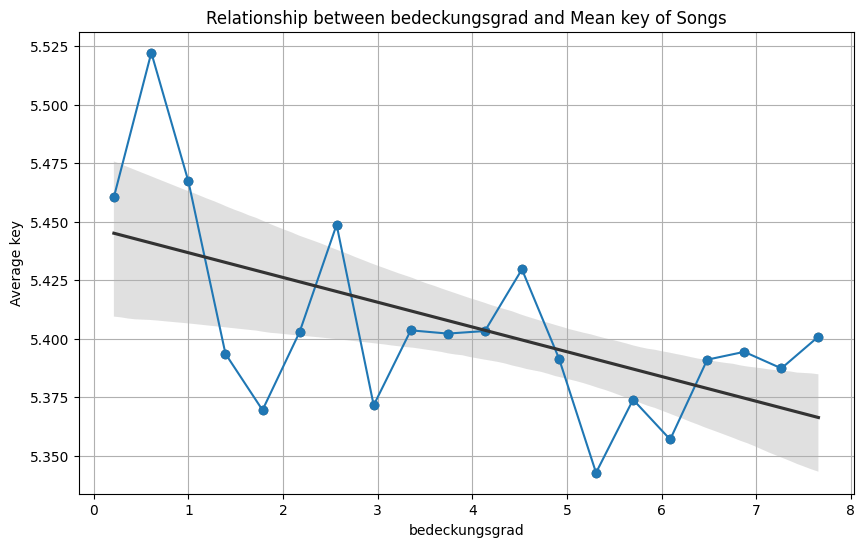

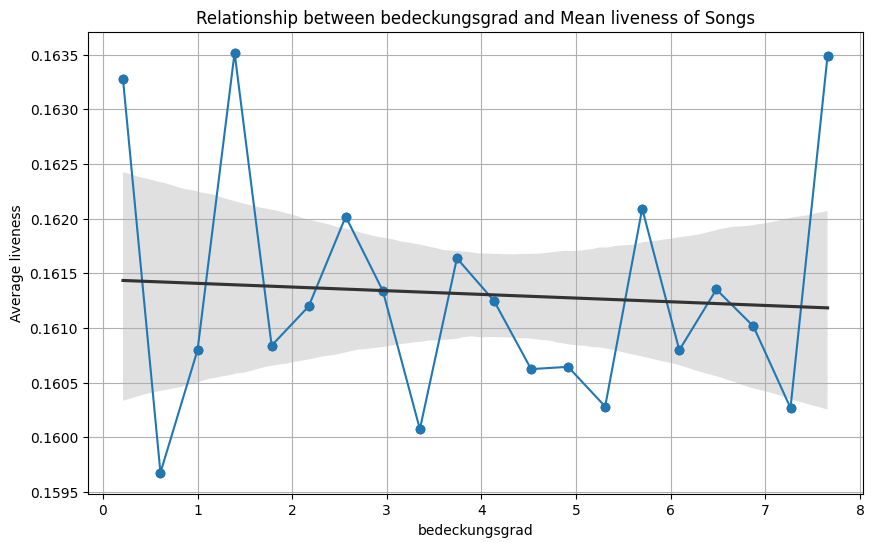

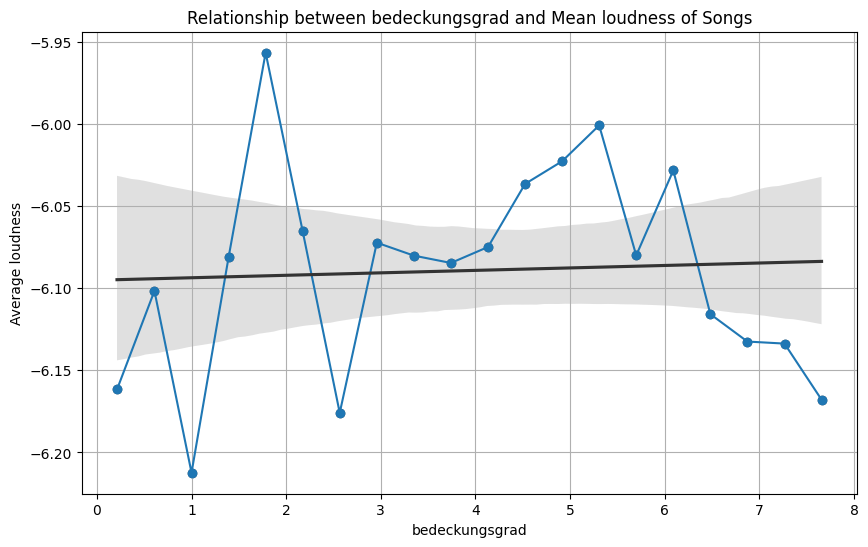

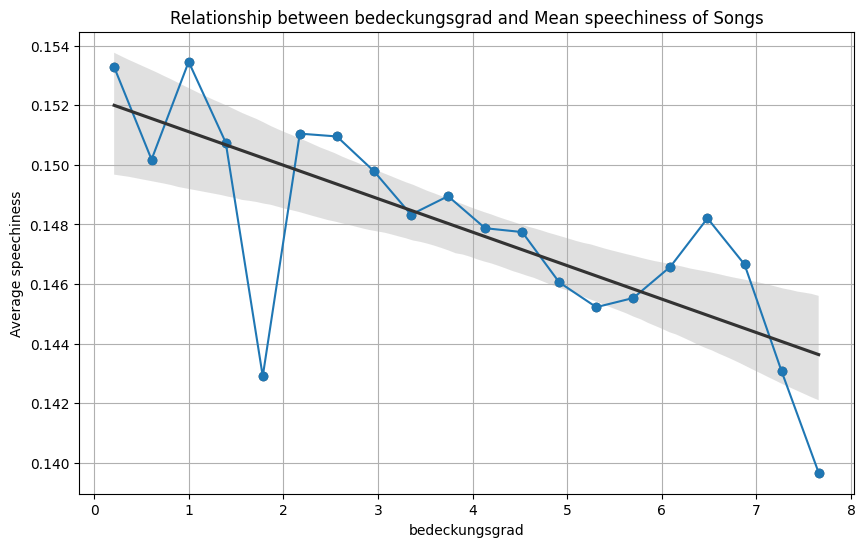

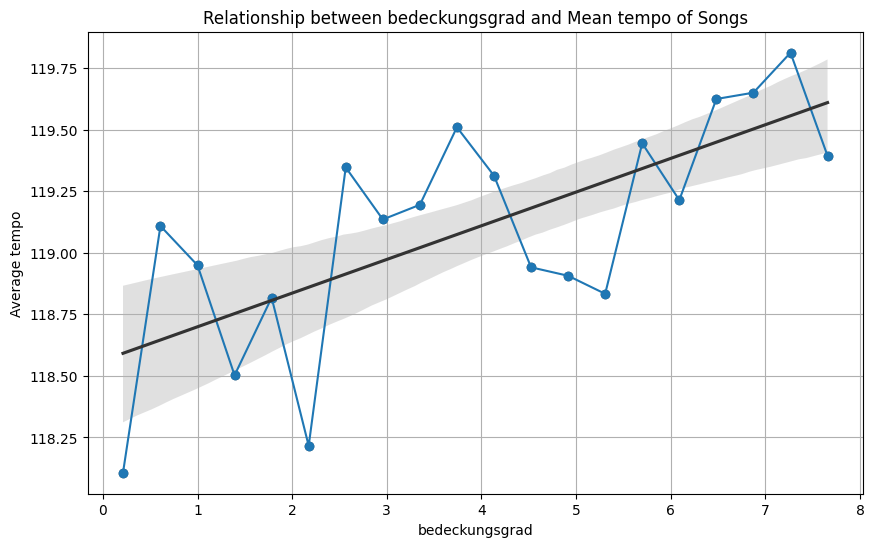

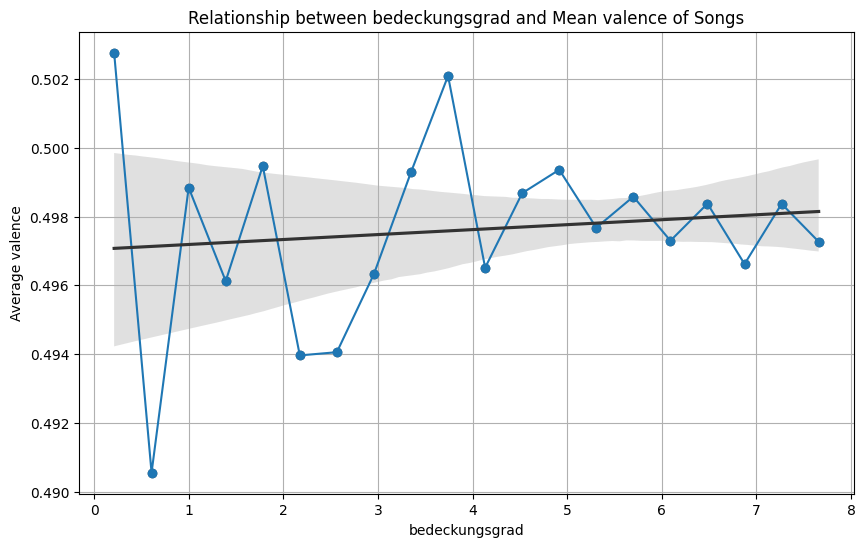

In [ ]:
merged_df = cloud_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["bedeckungsgrad"] + x_vars, y_vars=["bedeckungsgrad"])
plt.show()
plot_lines(merged_df, "bedeckungsgrad")

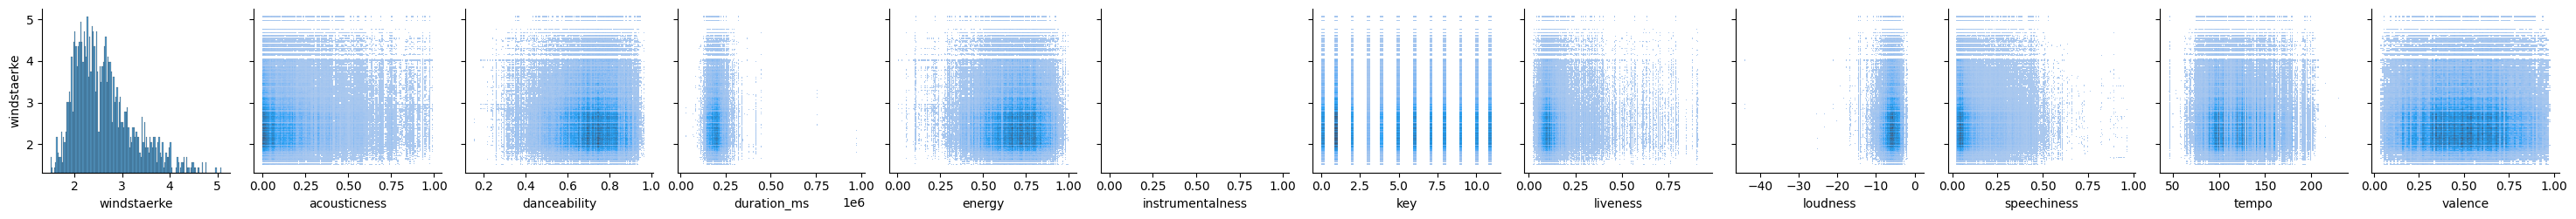

Bin Counts:
bin
(1.498, 1.68]      4000
(1.68, 1.859]      9800
(1.859, 2.038]    29600
(2.038, 2.217]    37600
(2.217, 2.396]    37600
(2.396, 2.575]    29999
(2.575, 2.753]    33200
(2.753, 2.932]    23600
(2.932, 3.111]    18200
(3.111, 3.29]     11200
(3.29, 3.469]      9800
(3.469, 3.648]     9200
(3.648, 3.827]     8000
(3.827, 4.005]     5000
(4.005, 4.184]     2400
(4.184, 4.363]     2400
(4.363, 4.542]     1600
(4.542, 4.721]     1000
(4.721, 4.9]        400
(4.9, 5.079]        400
Name: count, dtype: int64


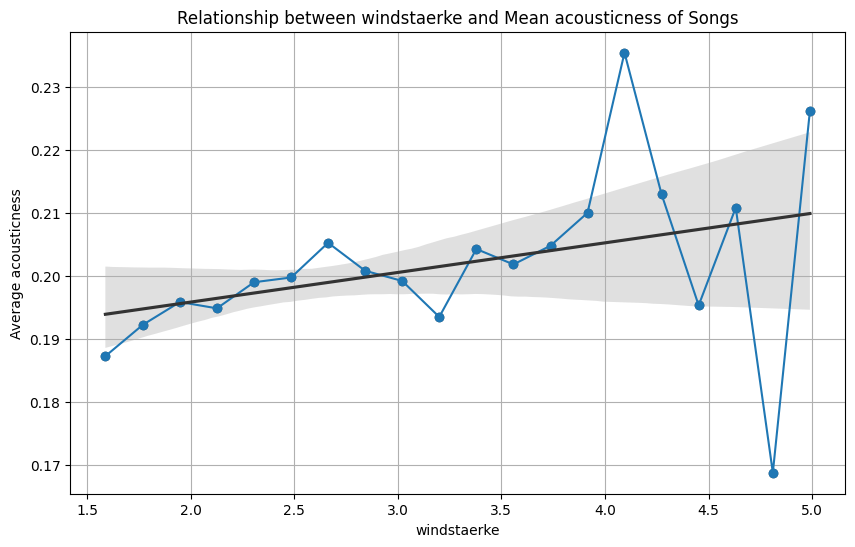

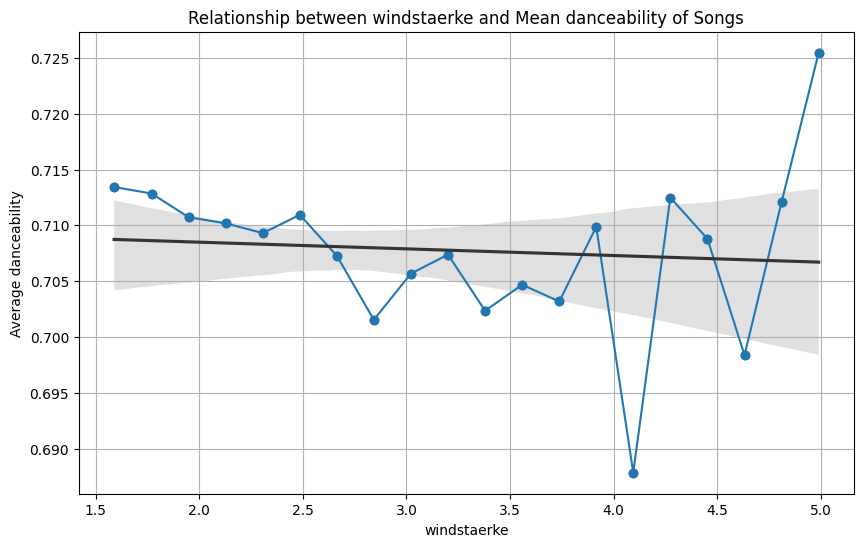

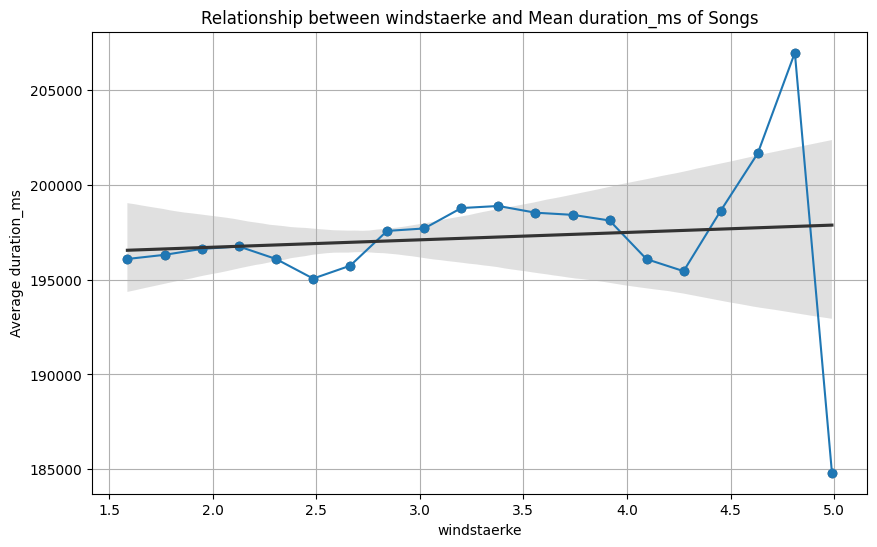

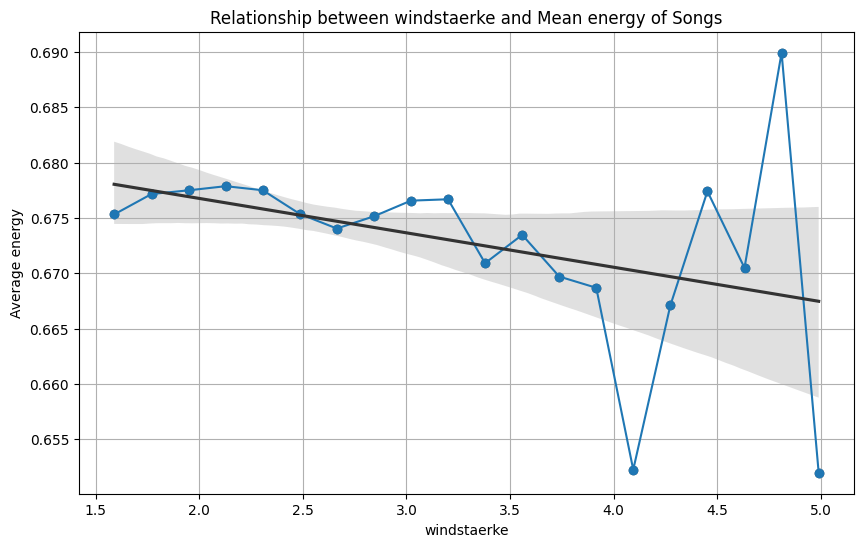

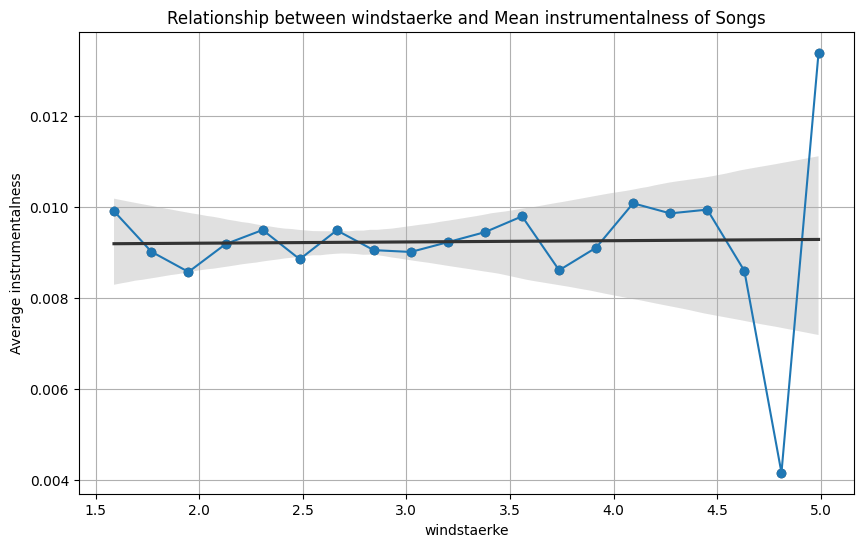

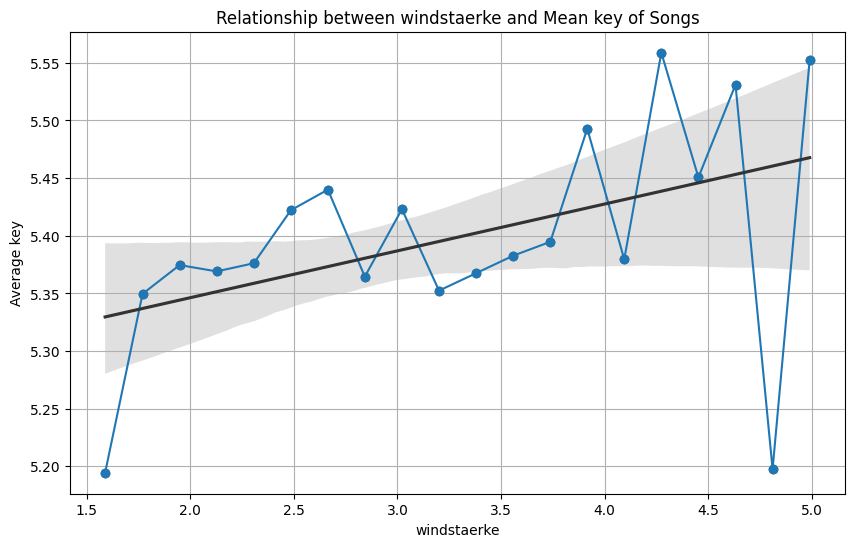

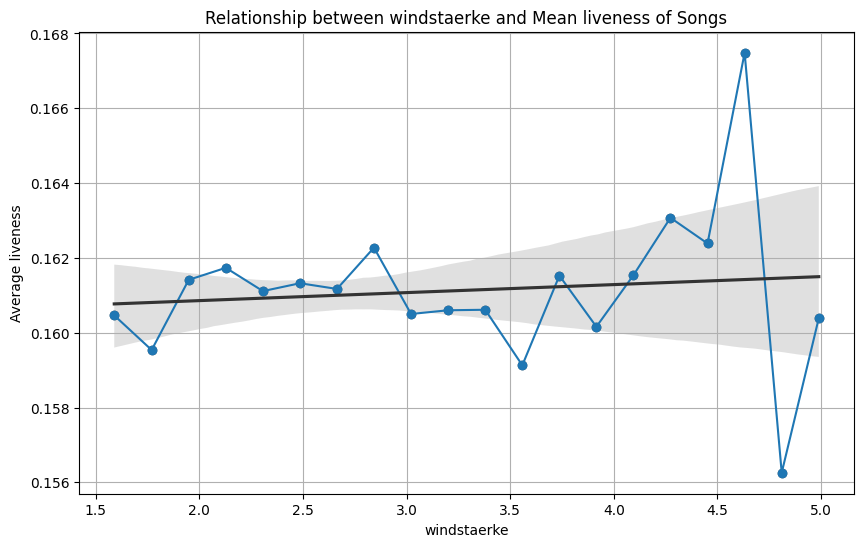

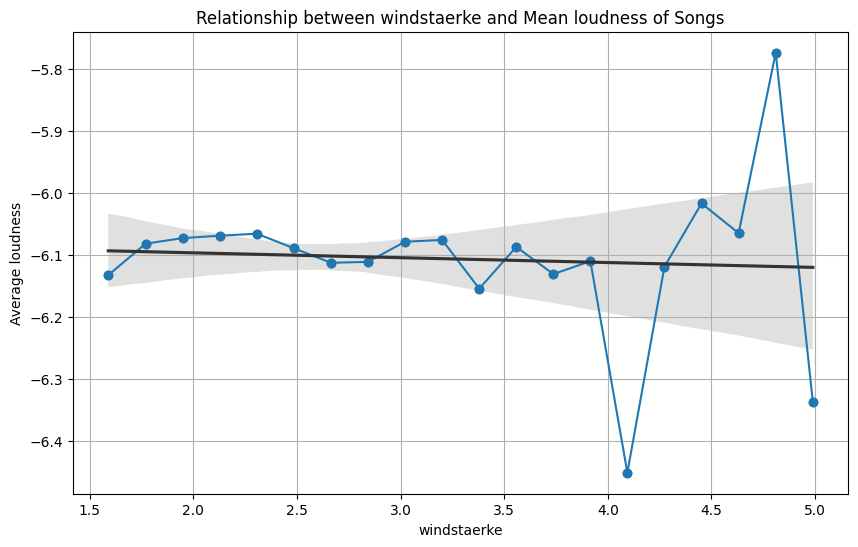

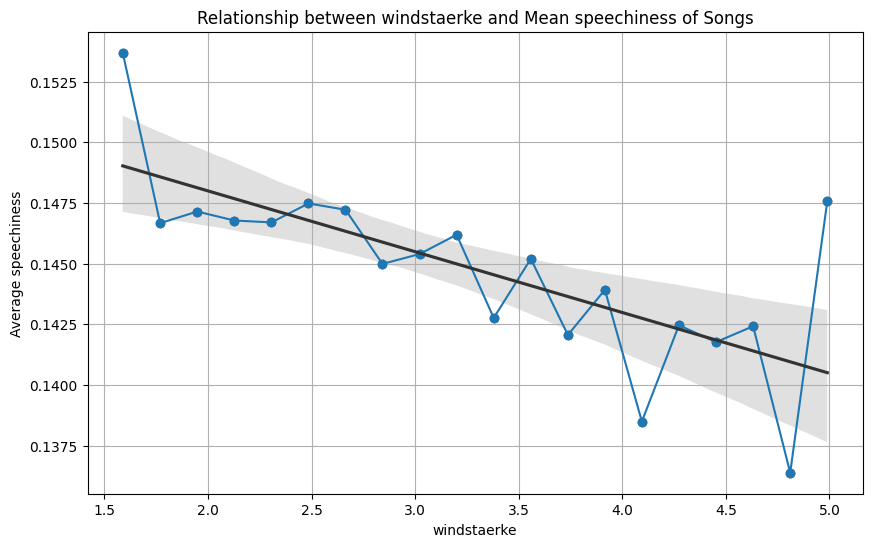

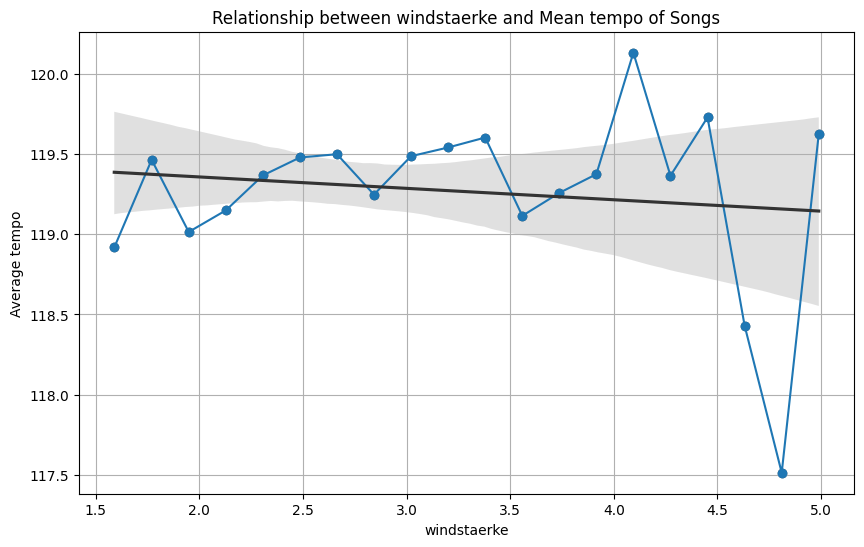

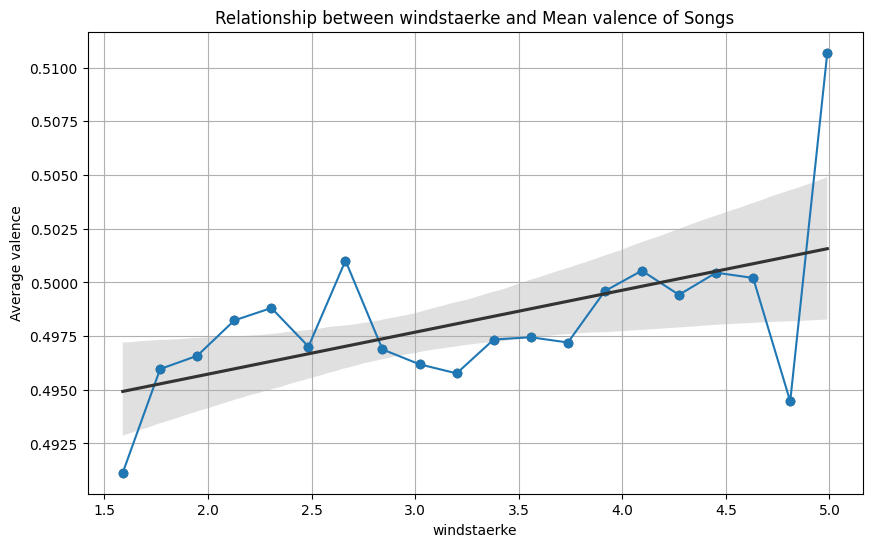

In [ ]:
merged_df = wind_df
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
sns.pairplot(merged_df, kind="hist", x_vars=["windstaerke"] + x_vars, y_vars=["windstaerke"])
plt.show()
plot_lines(merged_df, "windstaerke")

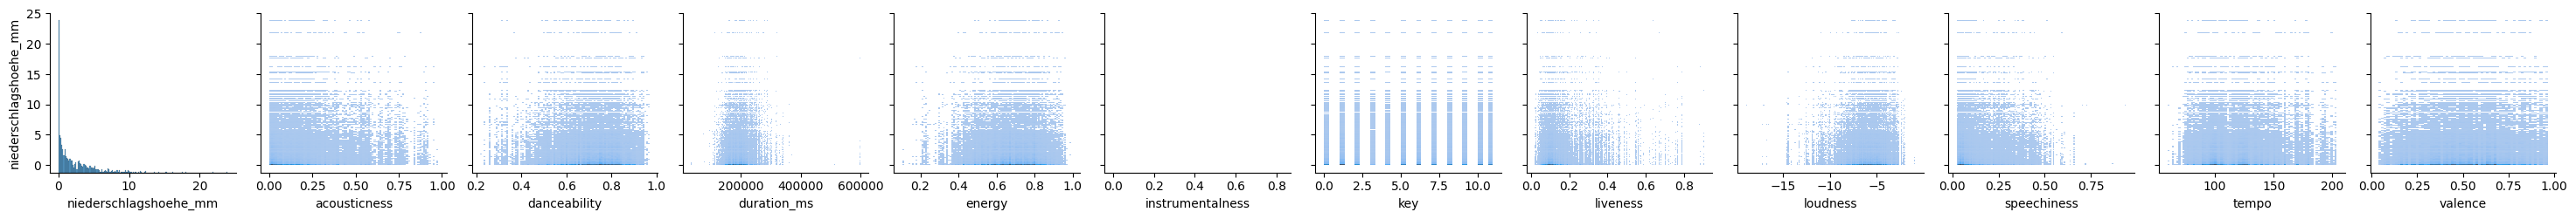

Bin Counts:
bin
(-0.0141, 1.183]    36500
(1.183, 2.366]       9750
(2.366, 3.549]       7600
(3.549, 4.732]       5350
(4.732, 5.916]       3200
(5.916, 7.099]       1500
(7.099, 8.282]       1350
(8.282, 9.465]        850
(9.465, 10.648]       850
(10.648, 11.831]      500
(11.831, 13.014]      250
(13.014, 14.197]      100
Name: count, dtype: int64


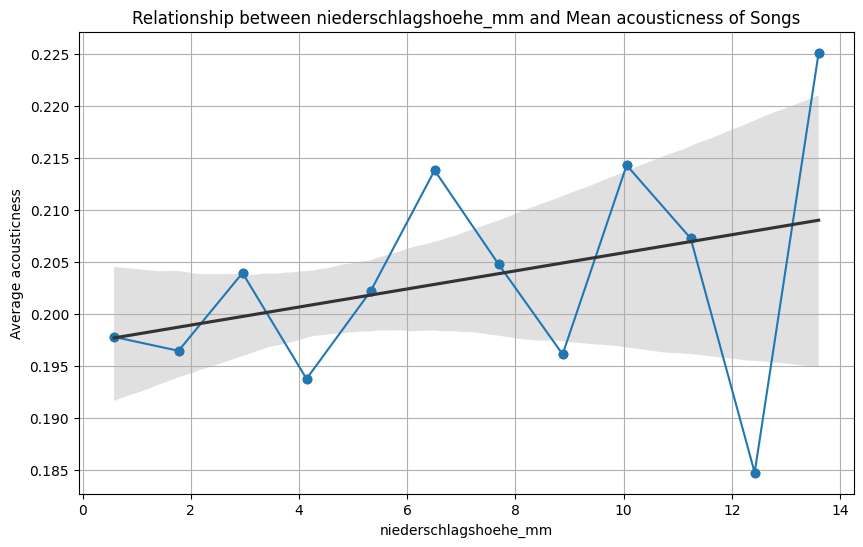

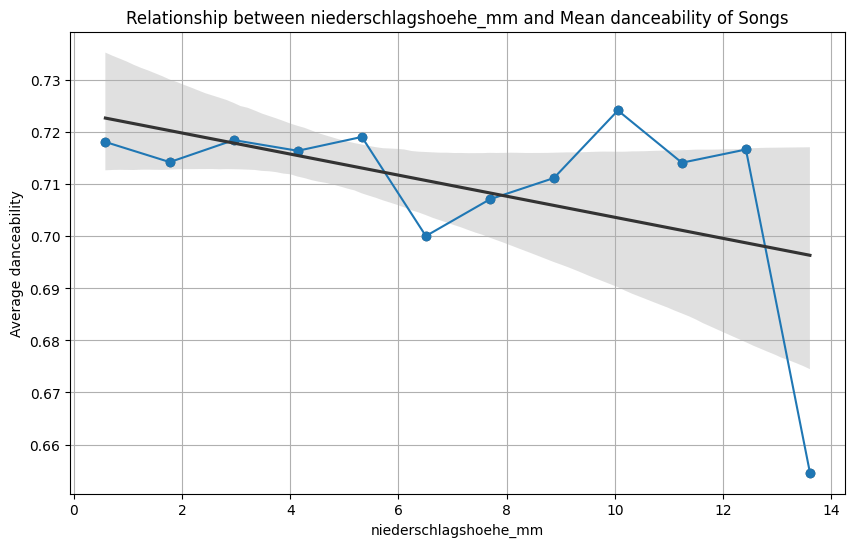

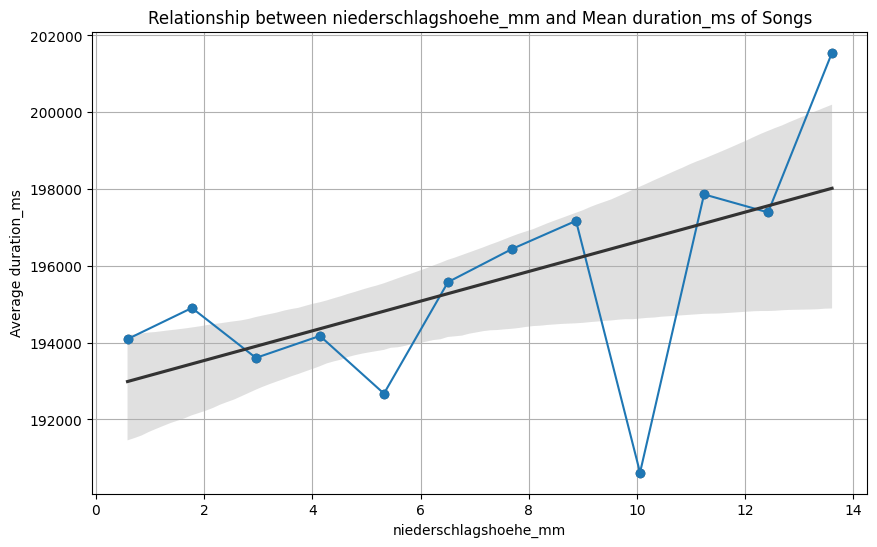

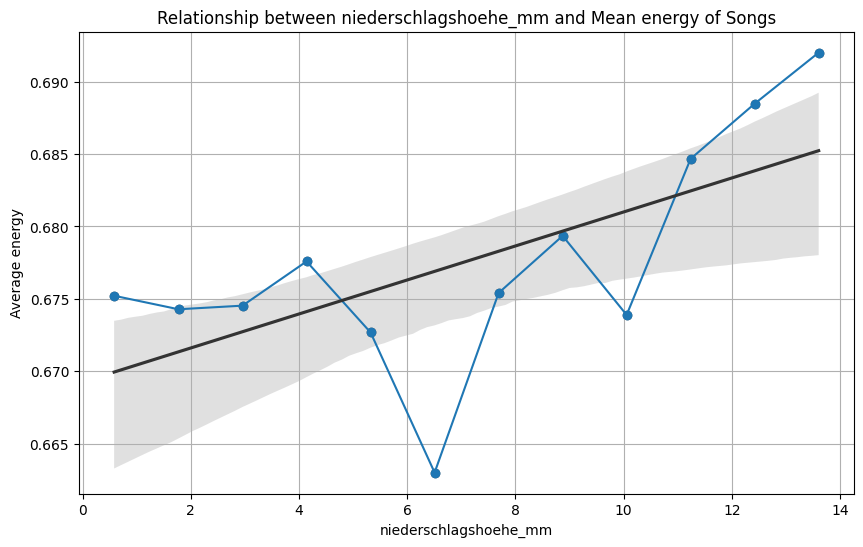

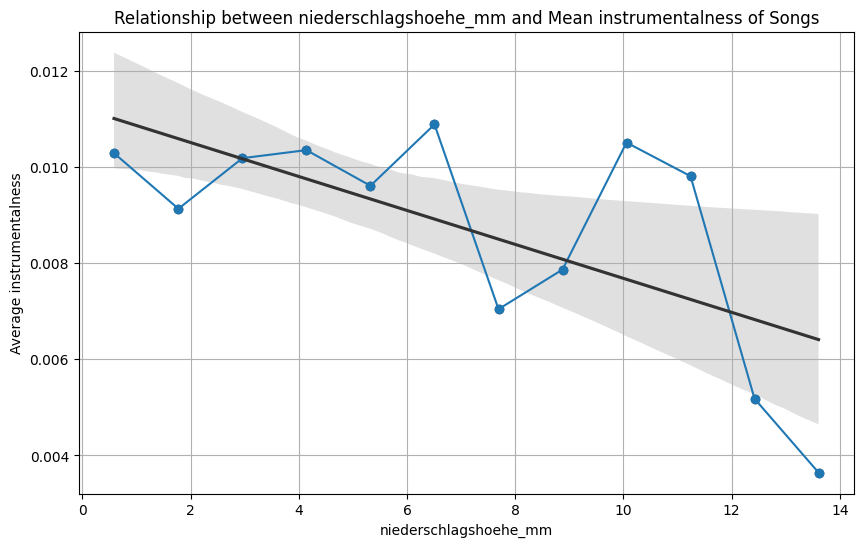

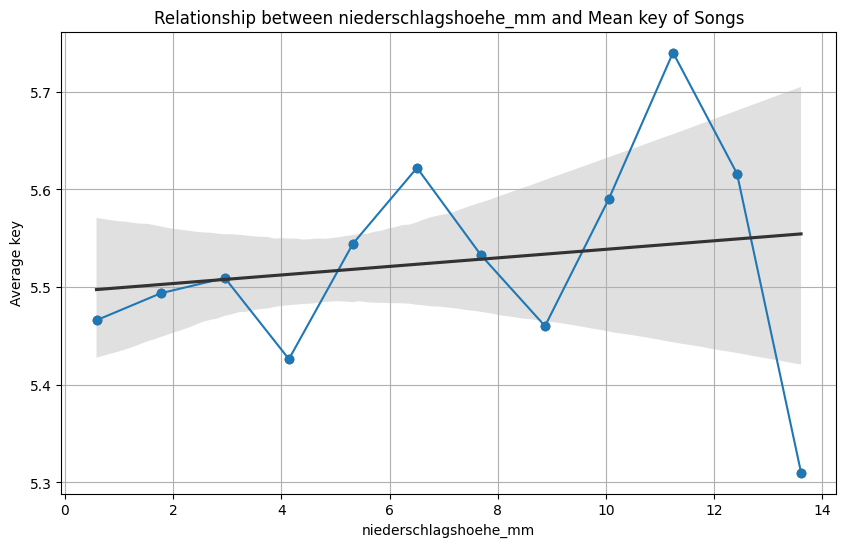

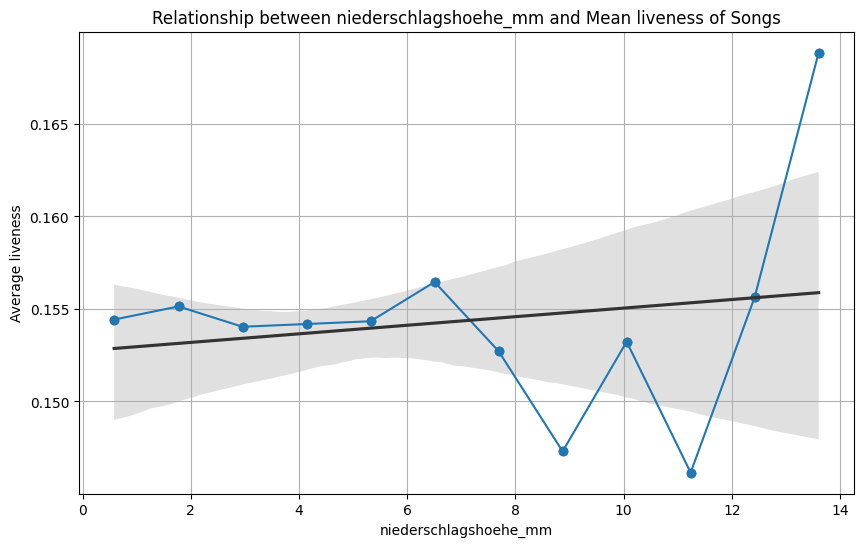

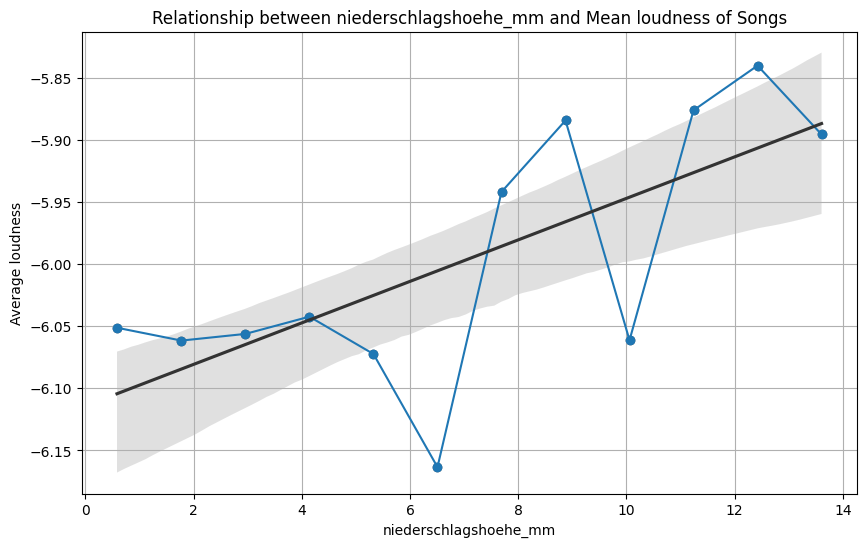

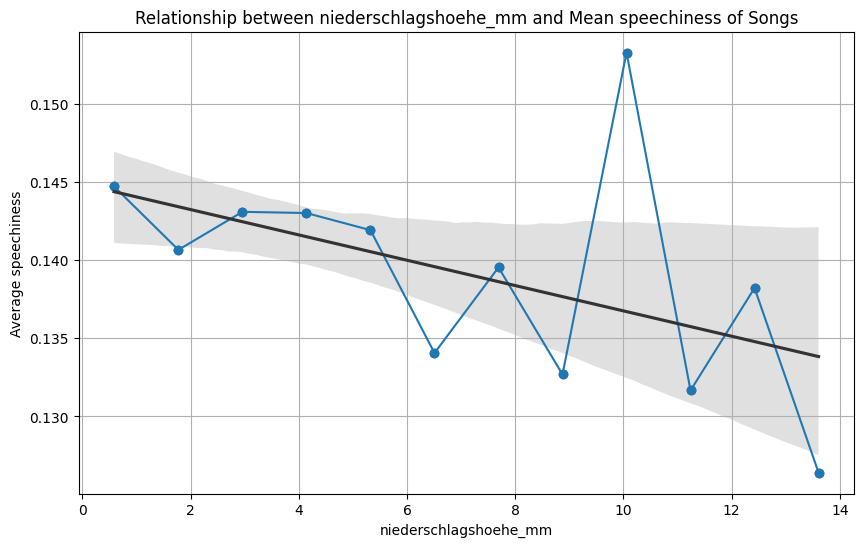

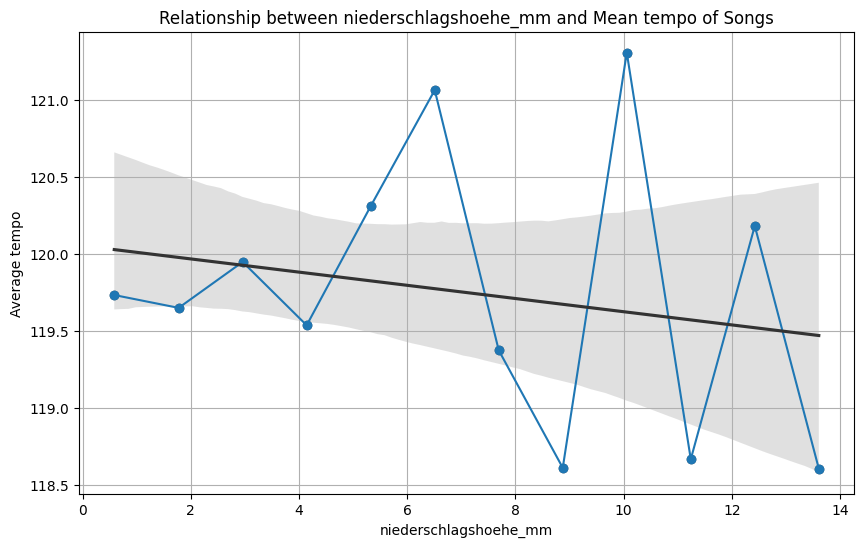

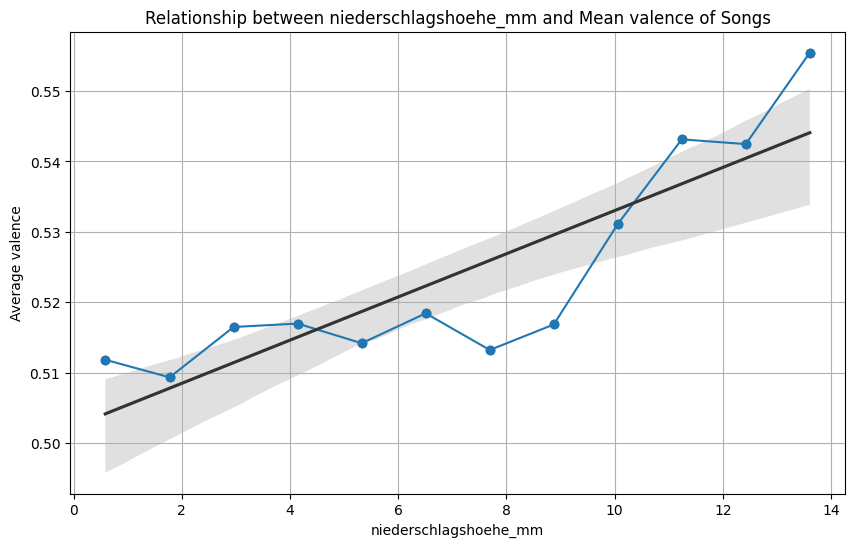

In [ ]:
merged_df = rain_df
merged_df = merged_df.merge(songs_df[songs_df["position"] <= 50], on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] > 0]
sns.pairplot(merged_df, kind="hist", x_vars=["niederschlagshoehe_mm"] + x_vars, y_vars=["niederschlagshoehe_mm"])
plt.show()
merged_df = merged_df[merged_df["niederschlagshoehe_mm"] <= 15]
plot_lines(merged_df, "niederschlagshoehe_mm", 12)

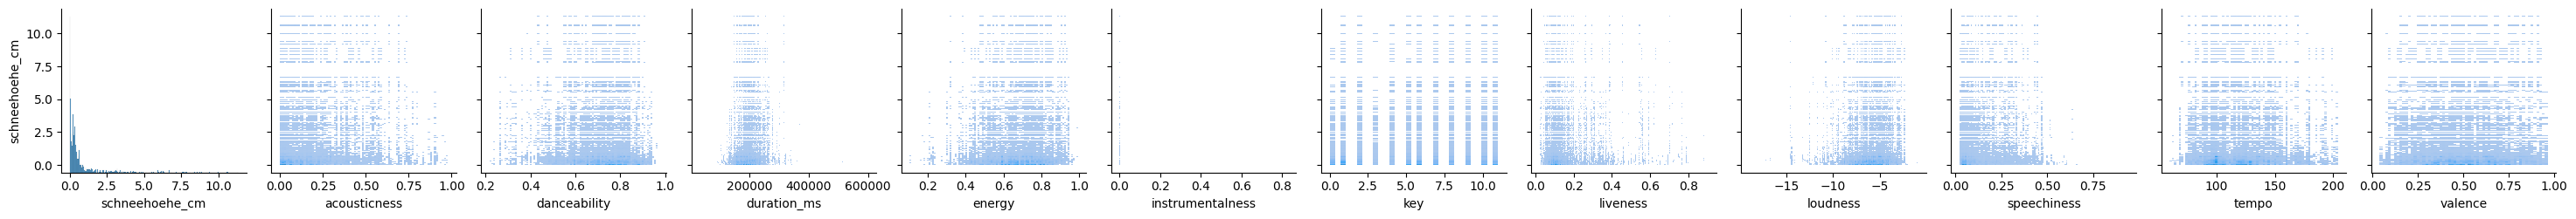

Bin Counts:
bin
(-0.00382, 0.329]    30400
(0.329, 0.657]       11750
(0.657, 0.985]        4100
(0.985, 1.313]        1650
(1.313, 1.642]        1300
(1.642, 1.97]         1000
(1.97, 2.298]          850
(2.298, 2.626]         650
(2.626, 2.954]         650
(2.954, 3.282]         950
(3.282, 3.61]          600
(3.61, 3.938]          450
(3.938, 4.266]         350
(4.266, 4.594]         300
(4.594, 4.923]         250
Name: count, dtype: int64


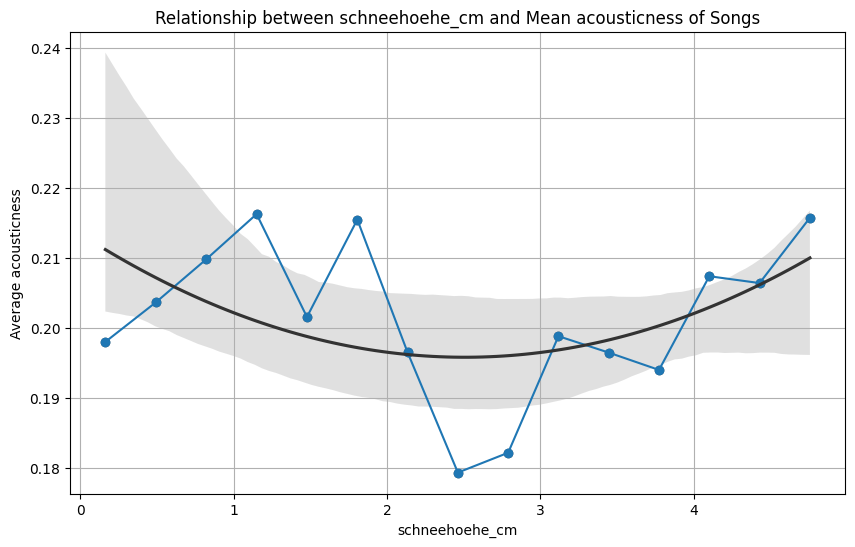

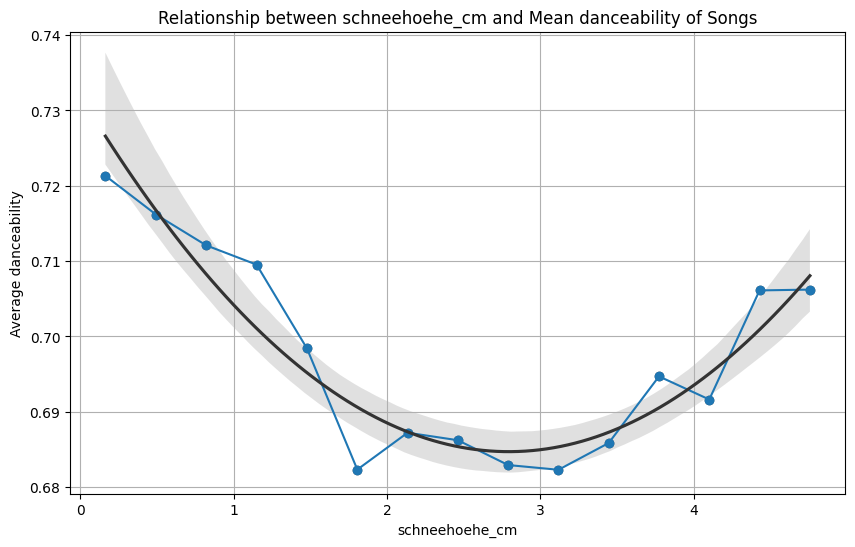

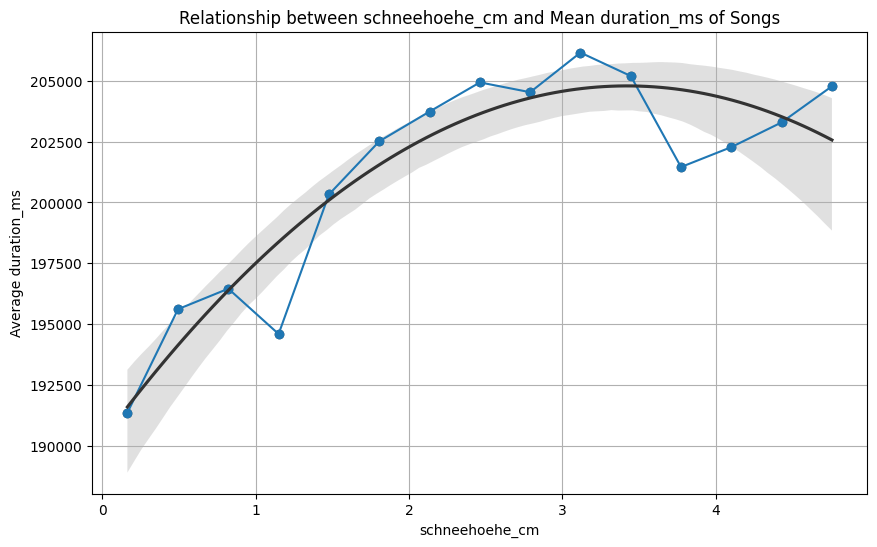

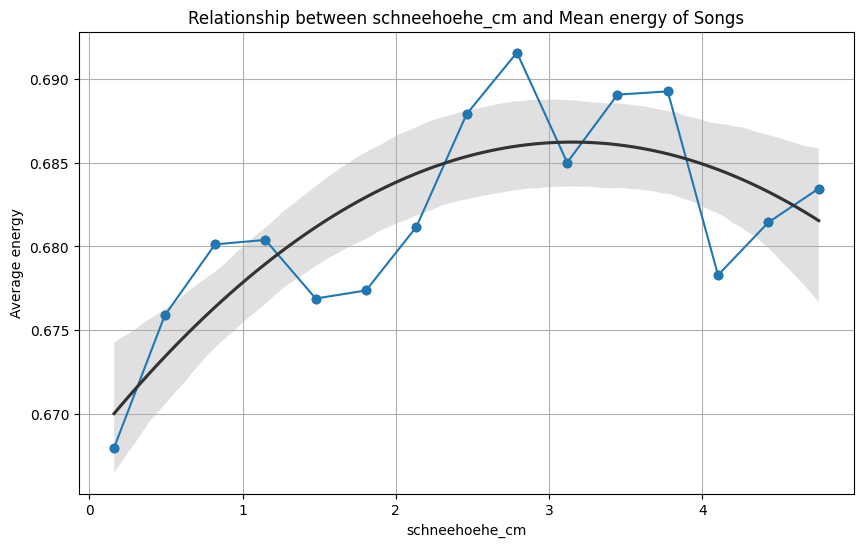

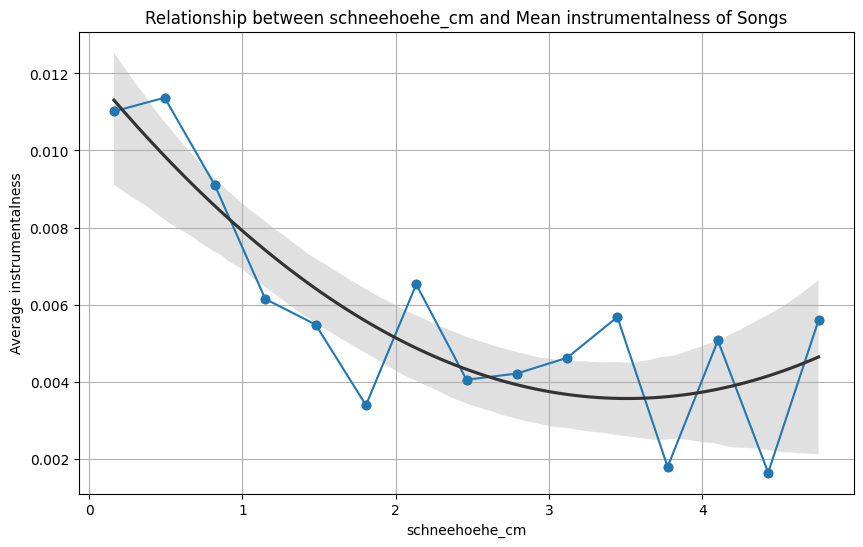

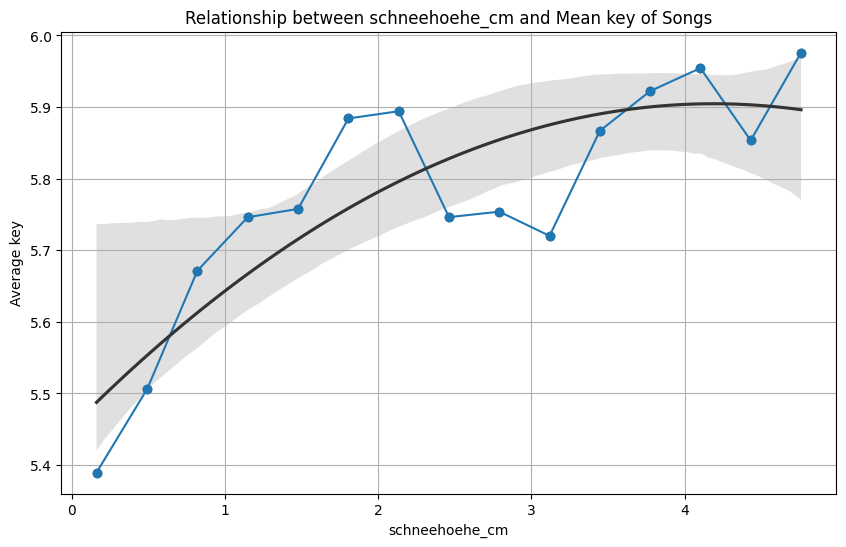

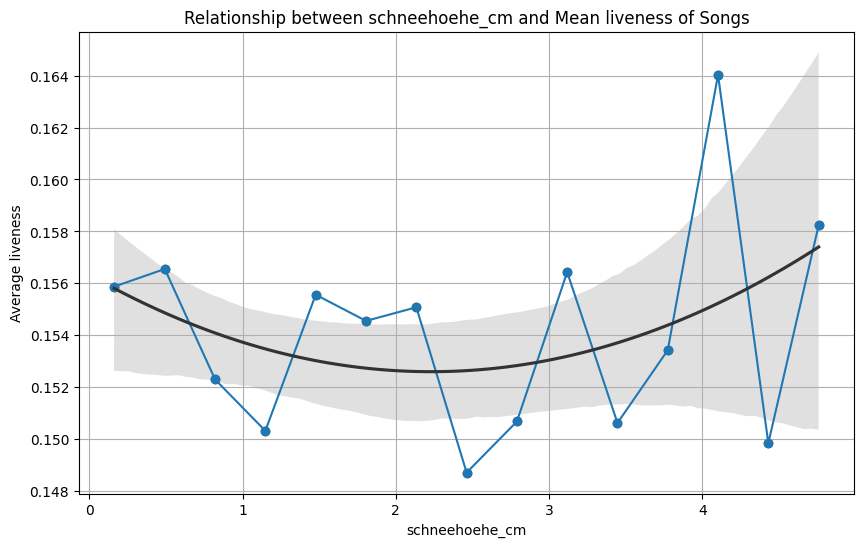

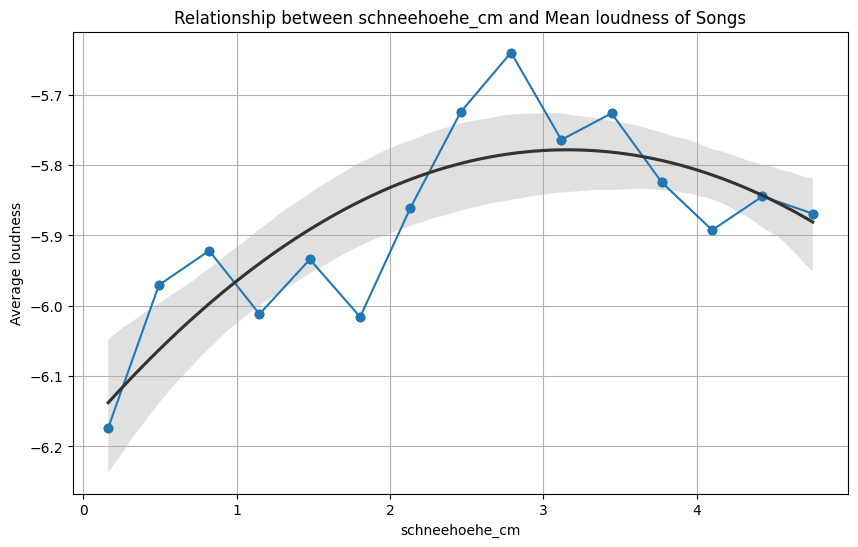

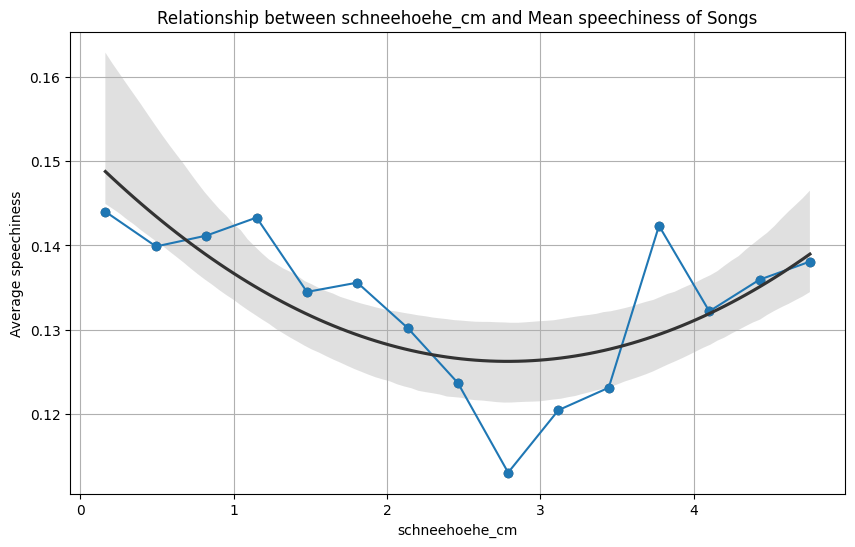

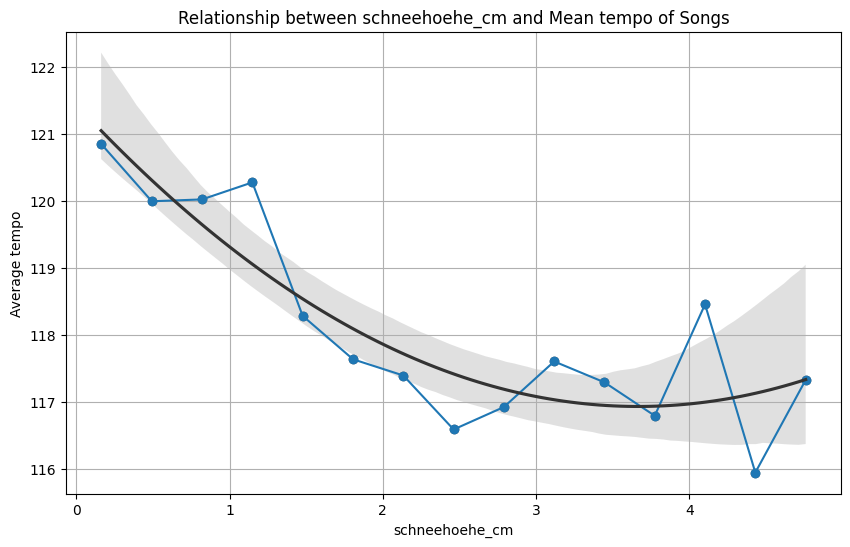

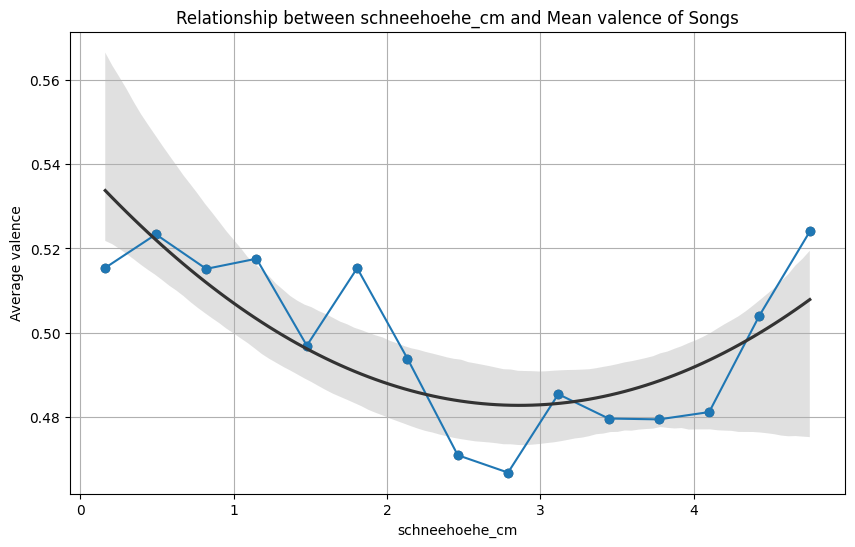

In [ ]:
merged_df = merged_df[merged_df["schneehoehe_cm"] > 0]
sns.pairplot(merged_df, kind="hist", x_vars=["schneehoehe_cm"] + x_vars, y_vars=["schneehoehe_cm"])
plt.show()
merged_df = merged_df[merged_df["schneehoehe_cm"] <= 5]
plot_lines(merged_df, "schneehoehe_cm", 15, 2)

## 4. Train and evaluate a Random Forest Regressor

In [6]:
# split data
merged_df = cloud_df
merged_df = merged_df.merge(rain_df, on="date")
merged_df = merged_df.merge(temperature_df, on="date")
merged_df = merged_df.merge(wind_df, on="date")
merged_df = merged_df.merge(songs_df, on="date")
merged_df = merged_df.merge(audio_features_df, on="track_id")

merged_df.dropna(inplace=True)

merged_df["bedeckungsgrad"] = merged_df["bedeckungsgrad"].astype("float64")
merged_df["niederschlagshoehe_mm"] = merged_df["niederschlagshoehe_mm"].astype("float64")
merged_df["schneehoehe_cm"] = merged_df["schneehoehe_cm"].astype("float64")
merged_df["neuschneehoehe_cm"] = merged_df["neuschneehoehe_cm"].astype("float64")
merged_df["lufttemperatur"] = merged_df["lufttemperatur"].astype("float64")
merged_df["rel_feuchte"] = merged_df["rel_feuchte"].astype("float64")
merged_df["windstaerke"] = merged_df["windstaerke"].astype("float64")

merged_df.columns = merged_df.columns.map(str)

x_df = merged_df.drop(["position", "date", "track_id", "track", "title", "artist"], axis=1)
y_df = merged_df["position"]

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25)

In [25]:
# fit AdaBoostRegressor
SEED = 42
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=10, random_state=SEED)
abr = AdaBoostRegressor(estimator=reg, n_estimators=50, random_state=SEED)
abr.fit(x_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                  random_state=42),
                  random_state=42)

In [15]:
# fit RandomForestRegressor
# parameter tuning guidelines https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
rfr = RandomForestRegressor(n_estimators=100, max_features=None, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=SEED)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_features=None, n_jobs=-1, random_state=42)

In [26]:
# evaluate
mean_value = np.mean(y_train)
y_pred_mean = np.full_like(y_test, mean_value)
mse_mean = mean_squared_error(y_test, y_pred_mean)
print("Mean MSE (Baseline):", mse_mean)

y_pred_abr = abr.predict(x_test)
mse_abr = mean_squared_error(y_test, y_pred_abr)
print(f"AdaBoostRegressor MSE: {mse_abr}")

y_pred_rfr = rfr.predict(x_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
print(f"RandomForestRegressor MSE: {mse_rfr}")

Mean MSE (Baseline): 3332.847324124451
AdaBoostRegressor MSE: 3003.2858612521436
RandomForestRegressor MSE: 784.2371109850199


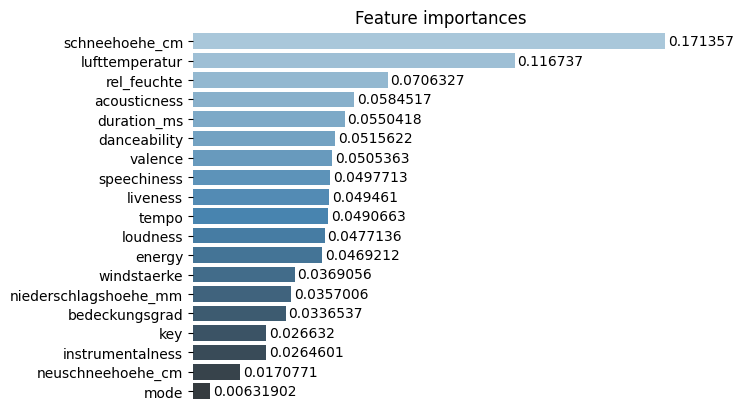

In [8]:
# visualize ranking of feature importances
features_df = pd.DataFrame({"features": rfr.feature_names_in_, "importances": rfr.feature_importances_ })
features_df_sorted = features_df.sort_values(by="importances", ascending=False)

plot = sns.barplot(data=features_df_sorted, x="importances", y ="features", palette="Blues_d")
sns.despine(bottom = True, left = True)
plot.set_title("Feature importances")
plot.set(xlabel=None)
plot.set(ylabel=None)
plot.set(xticks=[])
for value in plot.containers:
    plot.bar_label(value, padding=2)
plt.show()

## 5. Get current weather and song data

In [9]:
# get today's weather
FTP_URI: str = "opendata.dwd.de"
path_rain = "climate_environment/CDC/observations_germany/climate/daily/more_precip/recent/"
path_cloud = "climate_environment/CDC/observations_germany/climate/subdaily/cloudiness/recent/"
path_temperature = "climate_environment/CDC/observations_germany/climate/subdaily/air_temperature/recent/"
path_wind = "climate_environment/CDC/observations_germany/climate/subdaily/wind/recent/"

def get_dwd_data(data_src_name: str, path: str):
    df = None
    ftp = FTP(FTP_URI, timeout=20)
    ftp.login()
    directory_path, file_name = os.path.split(path)
    ftp.cwd(directory_path)

    # Get a list of all files
    files = ftp.nlst()

    # Create target directory
    raw_data_directory: str = os.path.join("temp", data_src_name)
    os.makedirs(raw_data_directory, exist_ok=True)

    # Download each file
    for file in files:
        local_filename: str = os.path.join(raw_data_directory, file)
        with open(local_filename, "wb") as f:
            def callback(chunk):
                f.write(chunk)
            ftp.retrbinary("RETR " + file, callback)
    ftp.quit()

    # Get a list of all zip files in the directory
    zip_files = [file for file in os.listdir(raw_data_directory) if file.endswith(".zip")]
    for zip_file in zip_files:
        zip_path = os.path.join(raw_data_directory, zip_file)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            # Get a list of member files contained in the zip file (excluding metadata files)
            member_files = [member for member in zip_ref.namelist() if not member.startswith("Metadaten_")]
            for member in member_files:
                # Read each member file into a DataFrame
                with zip_ref.open(name=member, mode="r") as tmpfile:
                    df = pd.read_csv(tmpfile, sep=";")
                    # Convert MESS_DATUM column to datetime format
                    try:
                        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H")
                    except:
                        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d")

    # delete temp directory
    shutil.rmtree(raw_data_directory)

    return df

# NOTE: this data is a few hours old because the DWD does not update it more frequently
rain_today_df = get_dwd_data("rain", path_rain)
cloud_today_df = get_dwd_data("rain", path_cloud)
temperature_today_df = get_dwd_data("rain", path_temperature)
wind_today_df = get_dwd_data("rain", path_wind)



TypeError: GroupBy.mean() got an unexpected keyword argument 'inplace'

In [ ]:
weather_today_df = rain_today_df
weather_today_df = weather_today_df.merge(cloud_today_df, on="MESS_DATUM", suffixes=("_rain", "_cloud"))
weather_today_df = weather_today_df.merge(temperature_today_df, on="MESS_DATUM", suffixes=("_cloud", "_temp"))
weather_today_df = weather_today_df.merge(wind_today_df, on="MESS_DATUM", suffixes=("_temp", "_wind"))

weather_today_df.drop(columns=["QN_6", " RSF", "QN_4_cloud", "CD_TER", "QN_4_temp", "QN_4", "DK_TER"], inplace=True)
weather_today_df.rename(columns={"MESS_DATUM": "date", "  RS": "niederschlagshoehe_mm", "SH_TAG": "schneehoehe_cm", "NSH_TAG": "neuschneehoehe_cm", "N_TER": "bedeckungsgrad", "TT_TER": "lufttemperatur", "RF_TER": "rel_feuchte", "FK_TER": "windstaerke"}, inplace=True)

weather_today_df = weather_today_df[weather_today_df["date"] == weather_today_df["date"].max()]
weather_today_df.drop(columns=["date"], inplace=True)

         date  niederschlagshoehe_mm  schneehoehe_cm  neuschneehoehe_cm   
79 2023-06-19                    0.9               0                  0  \
80 2023-06-20                    5.8               0                  0   
81 2023-06-21                    1.4               0                  0   
82 2023-06-22                    1.5               0                  0   
83 2023-06-23                    0.0               0                  0   

   bedeckungsgrad  lufttemperatur  rel_feuchte  windstaerke  
79              8            13.9         93.0            1  
80              8            17.0         97.0            1  
81              8            18.7         91.0            2  
82              8            14.7         97.0            1  
83              8            16.7         89.0            2  


In [ ]:
# get spotify's top songs for today
lines = open("../data/spotify_credentials.txt", "r").readlines()
SPOTIFY_CLIENT_ID = lines[0].strip()
SPOTIFY_CLIENT_SECRET = lines[1].strip()
auth_manager = spotipy.oauth2.SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=auth_manager)

top_50_germany_id = "37i9dQZEVXbJiZcmkrIHGU"
playlist = sp.playlist_items(top_50_germany_id)
playlist_uris = [item["track"]["uri"] for item in playlist["items"]]

new_features = sp.audio_features(playlist_uris)
audio_features_df = pd.DataFrame.from_dict(new_features)
audio_features_df.drop(columns=["type", "id", "uri", "track_href", "analysis_url", "time_signature"], inplace=True)

print(audio_features_df.head())

   danceability  energy  key  loudness  mode  speechiness  acousticness   
0         0.790   0.979   11    -4.637     0        0.117        0.0177  \
1         0.550   0.500    7    -5.779     0        0.045        0.2850   
2         0.667   0.702    0    -8.490     0        0.169        0.2190   
3         0.830   0.536    8   -12.094     0        0.165        0.0852   
4         0.837   0.944    0    -6.516     1        0.352        0.1080   

   instrumentalness  liveness  valence    tempo  duration_ms  
0          0.000192    0.2370    0.898  161.014       146087  
1          0.000000    0.1160    0.351  115.016       167357  
2          0.000043    0.1470    0.479  148.978       135302  
3          0.000000    0.0767    0.888  129.902       142183  
4          0.000085    0.1070    0.681  169.975       157059  


In [ ]:
# crossjoin weather and audio features
today_df = weather_today_df.merge(audio_features_df, how="cross")
# reorder columns
today_df = today_df[["bedeckungsgrad", "niederschlagshoehe_mm", "schneehoehe_cm", "neuschneehoehe_cm", "lufttemperatur", "rel_feuchte", "windstaerke", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]
print(today_df.head())

  bedeckungsgrad  niederschlagshoehe_mm  schneehoehe_cm  neuschneehoehe_cm   
0              8                    0.0               0                  0  \
1              8                    0.0               0                  0   
2              8                    0.0               0                  0   
3              8                    0.0               0                  0   
4              8                    0.0               0                  0   

   lufttemperatur  rel_feuchte  windstaerke  acousticness  danceability   
0            16.7         89.0            2        0.0177         0.790  \
1            16.7         89.0            2        0.2850         0.550   
2            16.7         89.0            2        0.2190         0.667   
3            16.7         89.0            2        0.0852         0.830   
4            16.7         89.0            2        0.1080         0.837   

   duration_ms  energy  instrumentalness  key  liveness  loudness  mode   
0    

## 6. Run song recommender

In [ ]:
# generate a prediction for the top songs for today
today_pred = rfr.predict(today_df)

# get the highest predicted song ranking
best_pred_position = today_pred.argmin()

most_recent_date = weather_today_df["date"].max()
print(f"[latest weather data is from {most_recent_date}]")
print(f"Today's top song is \"{playlist['items'][best_pred_position]['track']['name']}\" by {playlist['items'][best_pred_position]['track']['artists'][0]['name']} with a predicted popularity of {today_pred[best_pred_position]}.")

# show embed
track_id = playlist["items"][best_pred_position]["track"]["id"]
spotify_embed_url = f"https://open.spotify.com/embed/track/{track_id}"
display.display(display.IFrame(spotify_embed_url, width=350, height=100))


Today's top song is "Roller" by Apache 207 with a predicted popularity of 26.7.
